In [0]:
###install pytorch in colab
# !pip3 install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
# !pip3 install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl

In [1]:
##mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import json
import pandas as pd
import torch
import time
import os
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn.init as init

In [0]:
base_path = '/content/drive/My Drive/DL_exp/'

In [0]:
### custom dataset class for dataset. read the csv in __init__ . 
# input : csv file path
# output: returns (data,label)
class load_dataset(Dataset):
    def __init__(self, data_path):
        self.samples = pd.read_csv(data_path).values

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx,:-1] ,self.samples[idx,-1]
      
### Multilayer Perceptron Model
# input : number of features (input), hidden nodes list , number of classes
class MultilayerPerceptron(torch.nn.Module):
  
    def __init__(self,num_features,hidden_nodes_list,num_classes):
        super(MultilayerPerceptron, self).__init__()
        
        num_hidden_layes = len(hidden_nodes_list)
        self.hidden = torch.nn.ModuleList()
        
        self.hidden.append(torch.nn.Linear(num_features, hidden_nodes_list[0]))
        for k in range(num_hidden_layes-1):
            self.hidden.append(torch.nn.Linear(hidden_nodes_list[k], hidden_nodes_list[k+1]))    
        self.hidden.append(torch.nn.Linear(hidden_nodes_list[num_hidden_layes-1], num_classes))
        
    # input : features
    # output: logits , probabilities
    def forward(self, x):
        out = x
        for layer in self.hidden[:-1]:
          out = layer(out)
          out = F.relu(out)

        logits = self.hidden[-1](out)
        probas = F.log_softmax(logits, dim=1)
        return logits, probas
      
### weight initialization function
# use : model.apply(init_weights)
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    if initialisation_method=='xavier':
      init.xavier_uniform_(m.weight)
    if initialisation_method=='he':
      init.kaiming_uniform_(m.weight)
    m.bias.data.fill_(0.01)
    
### function to compute the accuracy
# input : model, data of type DataLoader
# output: cost (log loss), accuracy 
def compute_accuracy(net, data_loader):
    net.eval()
    cost, correct_pred, num_examples = 0, 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.float().to(device)
            targets = targets.long().to(device)
            logits, probas = net(features)
            cost += F.cross_entropy(logits, targets) * targets.size(0)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return cost/num_examples , correct_pred.float()/num_examples * 100
      
def perturb_weight(weight,perc):
  flatten_weight = weight.reshape(-1)
  norm = torch.norm(flatten_weight, p=1, dim=0)
  torch.manual_seed(1)
  noise = (torch.randn(len(flatten_weight))*norm*perc).to(device)
  new_weight = (flatten_weight + noise).reshape(weight.shape)
  return new_weight

In [105]:
### Training of multiple models
# Input: csv file path contain sphere-shell d dimension features,label data. 
# Its name is like 'train_sp1_sh1.8_t1_2dim.csv' where sphere, shell radius, shell thickness and dimension are variable that have to specify.
radius_of_sphere = 1
radius_of_shell = 1.2
thickness_of_shell = 1
dimentions = [2,4,8,16,32,64]          # list of dimention of the data
# Output: upade 'uniform_perturb_result.json' file with the data, trained model details, accuracy, epoch and loss
result_file = base_path+'result/uniform_perturb_result.json'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
start_time = time.time()

if os.path.isfile(result_file):
  with open(result_file, mode='r') as readjson:
    try: 
      result = json.loads(readjson.read())
    except ValueError: 
      result = [] 
else:
  with open(result_file, mode='w') as outfile:
      result = []
      json.dump(result, outfile)

for dim in dimentions:
  csv_path = base_path+'sphere_shell_data_version3_using_uniform/train_sp'+ str(radius_of_sphere) + '_sh'+ str(radius_of_shell) + '_t' + str(thickness_of_shell)+ '_' + str(dim) + 'dim.csv'
  dataset = load_dataset(csv_path)
  size = len(dataset)
  train_dataloader = DataLoader(dataset, batch_size=size, shuffle=True)

  tmp_h = [2,4,6,8,12,16,24,32,48,64,128,256]             #list of total number of nodes in hidden layers
  tmp_i = [100,200,300,400,500,600,700,800,900,1000]      #list of random seed for weight initialization
  # tmp_h = [2,4,8,16,32,64]
  
  for t_h in tmp_h:
    for t_i in tmp_i:

      #architecture
      num_features  = next(iter(dataset))[0].shape[0]        # Input data dimention
      hidden_nodes_list   = [t_h]                            # List of number of nodes at each hidden layer
      num_classes   = 2                                      # The number of output classes. In this case, 0 and 1
      
      # 'xavier' : Xavier Initialisation
      # 'he' : He Initialisation
      initialisation_method = 'xavier'
      
      # 'sgd' : SGD (lr) 
      # 'sgdwm' : SGD with Momentum (lr, momentum)
      # 'adagrad' : AdaGrad
      # 'adam' : Adam
      # 'ngd' : Natural gradient descent
      # 'l1' : L1 Regularisation
      # 'l2' : L2 Regularisation
      # 'pathnorm' : PathNorm Regularisation
      # 'spectralnorm' : Spectral norm Regularisation
      optimisation_method = 'sgdwm'  

      # Hyperparameters
      random_seed = t_i
      learning_rate = 0.05
            
      torch.manual_seed(random_seed)
      model = MultilayerPerceptron(num_features,hidden_nodes_list,num_classes)
      model.apply(init_weights)
      model = model.to(device)

      
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

      epoch = 0

      with torch.set_grad_enabled(False):
        cost,best_acc = compute_accuracy(model, train_dataloader)
      # print('Initial Before Perturbation: Epoch: %03d | Accuracy: %.2f%% | Cost: %.4f' % (epoch,best_acc,cost))
      
      count = 1
      prev_acc=best_acc
      best_epoch = epoch
      best_cost = cost

      while True:
          model.train()
          for batch_idx, (features, targets) in enumerate(train_dataloader):

              features = features.float().to(device)
              targets = targets.long().to(device)

              ### FORWARD AND BACK PROP
              logits, probas = model(features)
              cost = F.cross_entropy(logits, targets)
              optimizer.zero_grad()

              cost.backward()

              ### UPDATE MODEL PARAMETERS
              optimizer.step()

          with torch.set_grad_enabled(False):
              cost,acc = compute_accuracy(model, train_dataloader)
              
          epoch+=1 
          # Stopping conditions
          if prev_acc==acc:
            count+=1
          else:
            prev_acc=acc
            count=1
          if (epoch>50 and best_acc-acc>=5) or count==20 or epoch==400:
            break
          if acc>best_acc:
            best_acc=acc
            best_epoch = epoch
            best_cost = cost
 
      # print('Trained Before Perturbation: Epoch: %03d | Accuracy: %.2f%% | Cost: %.4f' % (best_epoch,best_acc,best_cost))
      before_perturb_epoch=best_epoch
      before_perturb_accuracy=best_acc.data.tolist()
      before_perturb_cost=best_cost.data.tolist()

      perturb_ratio = [0.1,0.2,0.4,0.8,1]
      
      for p in perturb_ratio:
        # print('---------------------------------------------------------------------------')
        copy_model = MultilayerPerceptron(num_features,hidden_nodes_list,num_classes)
        copy_model = copy_model.to(device)
        copy_model_dict = model.state_dict()

        for name in copy_model_dict:
          if name=='hidden.1.weight':
            copy_model_dict[name] = perturb_weight(copy_model_dict[name],p)
        copy_model.state_dict().update(copy_model_dict)
        copy_model.load_state_dict(copy_model_dict)
        
        optimizer = torch.optim.SGD(copy_model.parameters(), lr=learning_rate, momentum=0.9)
        epoch = 0

        with torch.set_grad_enabled(False):
          cost,best_acc = compute_accuracy(copy_model, train_dataloader)
        # print('Initial After Perturbation: Epoch: %03d | Accuracy: %.2f%% | Cost: %.4f' % (epoch,best_acc,cost))
        
        after_perturb_initial_epoch=epoch
        after_perturb_initial_accuracy=best_acc.data.tolist()
        after_perturb_initial_cost=cost.data.tolist()

        count = 1
        prev_acc=best_acc
        best_epoch = epoch
        best_cost = cost

        while True:
            copy_model.train()
            for batch_idx, (features, targets) in enumerate(train_dataloader):
      
                features = features.float().to(device)
                targets = targets.long().to(device)

                ### FORWARD AND BACK PROP
                logits, probas = copy_model(features)
                cost = F.cross_entropy(logits, targets)
                optimizer.zero_grad()

                cost.backward()

                ### UPDATE MODEL PARAMETERS
                optimizer.step()

            with torch.set_grad_enabled(False):
                cost,acc = compute_accuracy(copy_model, train_dataloader)
                
            epoch+=1
            # Stopping conditions
            if prev_acc==acc:
              count+=1
            else:
              prev_acc=acc
              count=1
            if (epoch>50 and best_acc-acc>=5) or count==20 or epoch==400:
              break
            if acc>best_acc:
              best_acc=acc
              best_epoch = epoch
              best_cost = cost
     
        # print('Trained After Perturbation: Epoch: %03d | Accuracy: %.2f%% | Cost: %.4f' % (best_epoch,best_acc,best_cost))
        after_perturb_epoch=best_epoch
        after_perturb_accuracy=best_acc.data.tolist()
        after_perturb_cost=best_cost.data.tolist()
        
        entry = {'sphere_radius': 1, 'shell_radius': radius_of_shell, 'thickness' : 1, 'dimension':dim, 'n_nodes':hidden_nodes_list, 'random_seed':t_i, 
                 'before_perturb_epoch':before_perturb_epoch,'before_perturb_accuracy':before_perturb_accuracy,'before_perturb_cost':before_perturb_cost,
                 'after_perturb_initial_epoch':after_perturb_initial_epoch,'after_perturb_initial_accuracy':after_perturb_initial_accuracy, 
                 'after_perturb_initial_cost':after_perturb_initial_cost,'after_perturb_epoch':after_perturb_epoch,'after_perturb_accuracy':after_perturb_accuracy, 
                 'after_perturb_cost':after_perturb_cost,'perturb_ratio':p}
        result.append(entry)

      print(dim,t_h,t_i)

with open(result_file, mode='w') as feedjson:
  json.dump(result, feedjson)

print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

2 2 100
2 2 200
2 2 300
2 2 400
2 2 500
2 2 600
2 2 700
2 2 800
2 2 900
2 2 1000
2 4 100
2 4 200
2 4 300
2 4 400
2 4 500
2 4 600
2 4 700
2 4 800
2 4 900
2 4 1000
2 6 100
2 6 200
2 6 300
2 6 400
2 6 500
2 6 600
2 6 700
2 6 800
2 6 900
2 6 1000
2 8 100
2 8 200
2 8 300
2 8 400
2 8 500
2 8 600
2 8 700
2 8 800
2 8 900
2 8 1000
2 12 100
2 12 200
2 12 300
2 12 400
2 12 500
2 12 600
2 12 700
2 12 800
2 12 900
2 12 1000
2 16 100
2 16 200
2 16 300
2 16 400
2 16 500
2 16 600
2 16 700
2 16 800
2 16 900
2 16 1000
2 24 100
2 24 200
2 24 300
2 24 400
2 24 500
2 24 600
2 24 700
2 24 800
2 24 900
2 24 1000
2 32 100
2 32 200
2 32 300
2 32 400
2 32 500
2 32 600
2 32 700
2 32 800
2 32 900
2 32 1000
2 48 100
2 48 200
2 48 300
2 48 400
2 48 500
2 48 600
2 48 700
2 48 800
2 48 900
2 48 1000
2 64 100
2 64 200
2 64 300
2 64 400
2 64 500
2 64 600
2 64 700
2 64 800
2 64 900
2 64 1000
2 128 100
2 128 200
2 128 300
2 128 400
2 128 500
2 128 600
2 128 700
2 128 800
2 128 900
2 128 1000
2 256 100
2 256 200
2 256 300

In [6]:
with open(base_path+'result/uniform_perturb_result.json', mode='r') as readjson:
  result = json.loads(readjson.read())
print(len(result))
print(result[0])

7200
{'sphere_radius': 1, 'shell_radius': 1.4, 'thickness': 1, 'dimension': 64, 'n_nodes': [256], 'random_seed': 1000, 'before_perturb_epoch': 110, 'before_perturb_accuracy': 99.4000015258789, 'before_perturb_cost': 0.18543070554733276, 'after_perturb_initial_epoch': 0, 'after_perturb_initial_accuracy': 46.0, 'after_perturb_initial_cost': 111.4781723022461, 'after_perturb_epoch': 134, 'after_perturb_accuracy': 98.20000457763672, 'after_perturb_cost': 0.08598299324512482, 'perturb_ratio': 1}


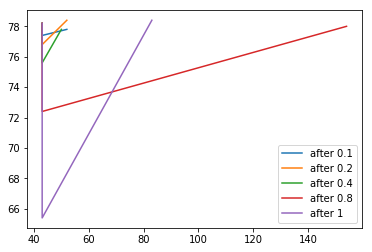

In [22]:
shell_radius = 1.4
rs = 200
nodes = 2
dim = 2 

a_1 = [[d['before_perturb_accuracy'],d['after_perturb_initial_accuracy'],d['after_perturb_accuracy']] for d in result if d['perturb_ratio']==0.1 and d['shell_radius']==shell_radius and d['random_seed']==rs  and d['n_nodes'][0]==nodes and d['dimension']==dim]
e_1 = [[d['before_perturb_epoch'],d['after_perturb_initial_epoch']+d['before_perturb_epoch'],d['after_perturb_epoch']+d['before_perturb_epoch']] for d in result if d['perturb_ratio']==0.1 and d['shell_radius']==shell_radius and d['random_seed']==rs  and d['n_nodes'][0]==nodes and d['dimension']==dim]

a_2 = [[d['before_perturb_accuracy'],d['after_perturb_initial_accuracy'],d['after_perturb_accuracy']] for d in result if d['perturb_ratio']==0.2 and d['shell_radius']==shell_radius and d['random_seed']==rs  and d['n_nodes'][0]==nodes and d['dimension']==dim]
e_2 = [[d['before_perturb_epoch'],d['after_perturb_initial_epoch']+d['before_perturb_epoch'],d['after_perturb_epoch']+d['before_perturb_epoch']] for d in result if d['perturb_ratio']==0.2 and d['shell_radius']==shell_radius and d['random_seed']==rs  and d['n_nodes'][0]==nodes and d['dimension']==dim]

a_4 = [[d['before_perturb_accuracy'],d['after_perturb_initial_accuracy'],d['after_perturb_accuracy']] for d in result if d['perturb_ratio']==0.4 and d['shell_radius']==shell_radius and d['random_seed']==rs  and d['n_nodes'][0]==nodes and d['dimension']==dim]
e_4 = [[d['before_perturb_epoch'],d['after_perturb_initial_epoch']+d['before_perturb_epoch'],d['after_perturb_epoch']+d['before_perturb_epoch']] for d in result if d['perturb_ratio']==0.4 and d['shell_radius']==shell_radius and d['random_seed']==rs  and d['n_nodes'][0]==nodes and d['dimension']==dim]

a_8 = [[d['before_perturb_accuracy'],d['after_perturb_initial_accuracy'],d['after_perturb_accuracy']] for d in result if d['perturb_ratio']==0.8 and d['shell_radius']==shell_radius and d['random_seed']==rs  and d['n_nodes'][0]==nodes and d['dimension']==dim]
e_8 = [[d['before_perturb_epoch'],d['after_perturb_initial_epoch']+d['before_perturb_epoch'],d['after_perturb_epoch']+d['before_perturb_epoch']] for d in result if d['perturb_ratio']==0.8 and d['shell_radius']==shell_radius and d['random_seed']==rs  and d['n_nodes'][0]==nodes and d['dimension']==dim]

a_10 = [[d['before_perturb_accuracy'],d['after_perturb_initial_accuracy'],d['after_perturb_accuracy']] for d in result if d['perturb_ratio']==1 and d['shell_radius']==shell_radius and d['random_seed']==rs  and d['n_nodes'][0]==nodes and d['dimension']==dim]
e_10 = [[d['before_perturb_epoch'],d['after_perturb_initial_epoch']+d['before_perturb_epoch'],d['after_perturb_epoch']+d['before_perturb_epoch']] for d in result if d['perturb_ratio']==1 and d['shell_radius']==shell_radius and d['random_seed']==rs  and d['n_nodes'][0]==nodes and d['dimension']==dim]

fig = plt.figure()
plt.plot(e_1[0],a_1[0],label='after 0.1')
plt.plot(e_2[0],a_2[0],label='after 0.2')
plt.plot(e_4[0],a_4[0],label='after 0.4')
plt.plot(e_8[0],a_8[0],label='after 0.8')
plt.plot(e_10[0],a_10[0],label='after 1')
plt.legend(loc='lower right')
# fig.set_size_inches(15, 10)
# axes = plt.gca()
# plt.yticks(np.arange(65, 95, 2))

In [16]:
e_1

[[97, 0, 59]]

In [7]:
pos=0
neg=0
p=[]
n=[]
for d in result:
  diff = d['after_perturb_accuracy']-d['before_perturb_accuracy']
  if diff>=0:
    pos+=1
    p.append(d['n_nodes'][0])
  else:
    neg+=1
    n.append(d['n_nodes'][0])
print(pos,neg)
print([(i,p.count(i)) for i in set(p) ])
print([(i,n.count(i)) for i in set(n) ])

3976 3224
[(32, 264), (64, 408), (2, 512), (128, 258), (4, 403), (256, 466), (6, 376), (8, 63), (12, 175), (16, 339), (48, 354), (24, 358)]
[(32, 336), (64, 192), (2, 88), (128, 342), (4, 197), (256, 134), (6, 224), (8, 537), (12, 425), (16, 261), (48, 246), (24, 242)]
